In [ ]:
! pip install numba

     |████████████████████████████████| 3.4 MB 14.3 MB/s 
     |████████████████████████████████| 25.3 MB 38.7 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# Start writing code here...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numba import jit

import itertools

import gc



In [ ]:
def get_trans_mat(p, q_lose_ratio, q_win, max_money, start_money):
    """
    p: probability to win a game
    q_lose: if a person loses, the probability to go back to the games with start money
    q_win: if a person wins, the probability to go back to the games with start money
    max_money: the money amount reached when a person feels that he wins and would like 
        to stay idle for a while
    start_money: the money amount to start a new round with for any gambler
    returns transitional matrix 
    """
    n = max_money + 3

    trans_mat = np.matrix(np.zeros((n, n)))

    for _ in range(1, max_money):
        trans_mat[_ + 1, _] = p
        trans_mat[_ - 1, _] = 1 - p

    idle_lose = max_money + 1
    idle_win = max_money + 2

    q_lose = q_lose_ratio * p
    trans_mat[idle_lose, 0] = 1
    trans_mat[idle_lose, idle_lose] = 1 - q_lose 
    trans_mat[start_money, idle_lose] = q_lose 

    trans_mat[idle_win, max_money] = 1
    trans_mat[idle_win, idle_win] = 1 - q_win
    trans_mat[start_money, idle_win] = q_win

    return trans_mat


def get_trans_frame(p, q_lose_ratio, q_win, max_money, start_money):
    """
    p: probability to win a game
    q_lose: if a person loses, the probability to go back to the games with start money
    q_win: if a person wins, the probability to go back to the games with start money
    max_money: the money amount reached when a person feels that he wins and would like 
        to stay idle for a while
    start_money: the money amount to start a new round with for any gambler 
    """
    mat = get_trans_mat(p, q_lose_ratio, q_win, max_money, start_money)

    labels = list(range(max_money + 1)) + ['idle_lose', 'idle_win']
    return pd.DataFrame(mat, index=labels, columns=labels)

get_trans_frame(0.4, 0.25, 0.5, 6, 2)

,0,1,2,3,4,5,6,idle_lose,idle_win
0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.4,0.0,0.6,0.0,0.0,0.0,0.1,0.5
3,0.0,0.0,0.4,0.0,0.6,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.4,0.0,0.6,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0
idle_lose,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,0.0
idle_win,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5


In [ ]:
# simulate a markov chain path (state history) for a single gambler
@jit
def sim_single_gambler(n_steps, start_money, trans_arr):
    
    state_hist = [start_money]

    state_vals = np.array(np.arange(len(trans_arr)))

    for _ in range(n_steps):
        dist = trans_arr[:, state_hist[-1]]
        state_hist.append(
            # np.random.choice(state_vals, 1, True, dist)[0]
            choice(state_vals, dist)
        )

    return np.array(state_hist)

@jit
def choice(vals, dist):
    sums = np.cumsum(dist)

    r = np.random.random() * sums[-1]

    for _ in range(len(vals)):
        if r < sums[_]:
            return vals[_]





In [ ]:
# calculated the profit for the casino given the state history.
# service_profit_rate is not analyzed in this project
def get_casino_profit(state_hist, idle_states, start_money, service_profit_rate=0):
    hist_split = [
        list(group) 
        for k, group in 
        itertools.groupby(state_hist, lambda x: x in idle_states) if not k
    ]
    # return hist_split
    return sum([
        start_money - _[-1] if start_money > _[-1] 
        else (start_money - _[-1]) * (1 - service_profit_rate) 
        for _ in hist_split
    ])


In [ ]:
# calculated average profit per gambler with simulation
def sim_avg_profit(p, q_lose, q_win, max_money, start_money, n_gamblers, n_steps, service_profit_rate):
        """
    p: probability to win a game
    q_lose: if a person loses, the probability to go back to the games with start money
    q_win: if a person wins, the probability to go back to the games with start money
    max_money: the money amount reached when a person feels that he wins and would like 
        to stay idle for a while
    start_money: the money amount to start a new round with for any gambler 
    n_gamblers: number of gamblers
    n_steps: number of rounds
    """
    A = get_trans_mat(p, q_lose, q_win, max_money, start_money)

    # n_gablers =  10000
    gc.collect()
    realzns = np.array([
        sim_single_gambler(n_steps, start_money, np.array(A))
        for _ in range(n_gamblers)
    ])

    return np.mean([
        get_casino_profit(_, (max_money + 1, max_money + 2), start_money, service_profit_rate)
        for _ in realzns
    ])


### 

In [ ]:
#find the profit pattern with different start_money
profit_patterns_vstart = pd.DataFrame({
    start_money: pd.Series({
        _: sim_avg_profit(_, 0.25, 0.5, 6, start_money, 5000, 240, 0.0)
        for _ in np.linspace(0.0, 0.6, 61)
    })
    for start_money in [1, 2, 3, 4, 5]
})

/tmp/ipykernel_1216/855437988.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "sim_single_gambler" failed type inference due to: No implementation of function Function(<built-in function array>) found for signature:
 
 >>> array(array(int64, 1d, C))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'array': File: numba/core/typing/npydecl.py: Line 489.
    With argument(s): '(array(int64, 1d, C))':
   Rejected as the implementation raised a specific error:
     TypingError: array(int64, 1d, C) not allowed in a homogeneous sequence
  raised from /root/venv/lib/python3.7/site-packages/numba/core/typing/npydecl.py:457

During: resolving callee type: Function(<built-in function array>)
During: typing of call at /tmp/ipykernel_1216/855437988.py (5)


File "../tmp/ipykernel_1216/855437988.py", line 5:
<source missing, REPL/exec in use?>

  @jit
/tmp/ipykernel_1216/855437988.py:1: Numb

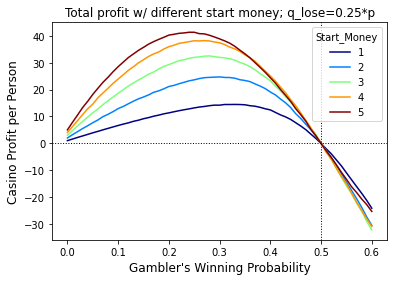

In [ ]:
#plot the profit pattern with different start_money
profit_patterns_vstart.to_csv('profit_qlose0.25_vstart.csv')
pp = profit_patterns_vstart.loc[:0.6].plot(
    cmap='jet', 
    title='Total profit w/ different start money; q_lose=0.25*p'
)
pp.set_xlabel("Gambler's Winning Probability", fontsize=12)
pp.set_ylabel('Casino Profit per Person', fontsize=12)
pp.legend(title='Start_Money',fontsize=10)
pp.axvline(0.5, lw=1, color='k', linestyle=':')
pp.axhline(0., lw=1, color='k', linestyle=':')



In [ ]:
#find the profit pattern with different q_win
profit_patterns_vqwin = pd.DataFrame({
    q_win: pd.Series({
        _: sim_avg_profit(_, 0.25, q_win, 6, 2, 5000, 240, 0.0)
        for _ in np.linspace(0.0, 0.6, 61)
    })
    for q_win in [0.1, 0.3, 0.5, 0.7, 0.9]
})

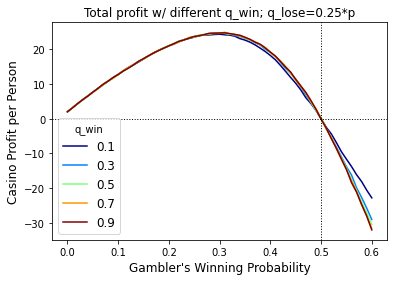

In [ ]:
#plot the profit pattern with different q_win
profit_patterns_vqwin.to_csv('profit_qlose0.25_vqwin.csv')
pp_vqwin = profit_patterns_vqwin.loc[:0.6].plot(
    cmap='jet', 
    title='Total profit w/ different q_win; q_lose=0.25*p',
)
pp_vqwin.set_xlabel("Gambler's Winning Probability", fontsize=12)
pp_vqwin.set_ylabel('Casino Profit per Person', fontsize=12)
pp_vqwin.legend(title='q_win',fontsize=12)
pp_vqwin.axvline(0.5, lw=1, color='k', linestyle=':')
pp_vqwin.axhline(0., lw=1, color='k', linestyle=':')

In [ ]:
#find the profit pattern with different q_win 
#when start_money = 5 and q_lose_ratio = 0.75
profit_start5_vqwin = pd.DataFrame({
    q_win: pd.Series({
        _: sim_avg_profit(_, 0.75, q_win, 6, 5, 5000, 240, 0.0)
        for _ in np.linspace(0.0, 0.6, 61)
    })
    for q_win in [0.1, 0.3, 0.5, 0.7, 0.9]
})

/tmp/ipykernel_73/855437988.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "sim_single_gambler" failed type inference due to: No implementation of function Function(<built-in function array>) found for signature:
 
 >>> array(array(int64, 1d, C))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'array': File: numba/core/typing/npydecl.py: Line 489.
    With argument(s): '(array(int64, 1d, C))':
   Rejected as the implementation raised a specific error:
     TypingError: array(int64, 1d, C) not allowed in a homogeneous sequence
  raised from /root/venv/lib/python3.7/site-packages/numba/core/typing/npydecl.py:457

During: resolving callee type: Function(<built-in function array>)
During: typing of call at /tmp/ipykernel_73/855437988.py (5)


File "../tmp/ipykernel_73/855437988.py", line 5:
<source missing, REPL/exec in use?>

  @jit
/tmp/ipykernel_73/855437988.py:1: NumbaWarning

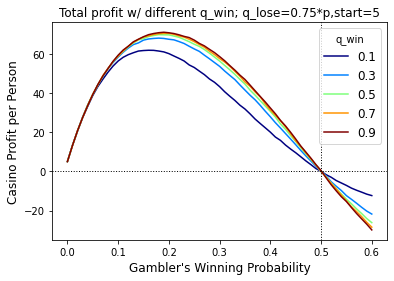

In [ ]:
#plot the profit pattern with different q_win 
#when start_money = 5 and q_lose_ratio = 0.75
profit_start5_vqwin.to_csv('profit_qlose0.75start5_vqwin.csv')
pp_vqwin1 = profit_start5_vqwin.loc[:0.6].plot(
    cmap='jet', 
    title='Total profit w/ different q_win; q_lose=0.75*p,start=5',
)
pp_vqwin1.set_xlabel("Gambler's Winning Probability", fontsize=12)
pp_vqwin1.set_ylabel('Casino Profit per Person', fontsize=12)
pp_vqwin1.legend(title='q_win',fontsize=12)
pp_vqwin1.axvline(0.5, lw=1, color='k', linestyle=':')
pp_vqwin1.axhline(0., lw=1, color='k', linestyle=':')

In [ ]:
#find the profit pattern with different start_money and max_money 
#and the ratio of max/start money = 1/3
profit_patterns_vmax = pd.DataFrame({
    max_money: pd.Series({
        _: sim_avg_profit(_, 0.25, 0.5, max_money, max_money//3, 5000, 240, 0.0)
        for _ in np.linspace(0.0, 0.6, 61)
    })
    for max_money in [4, 5, 6, 10, 20]
})

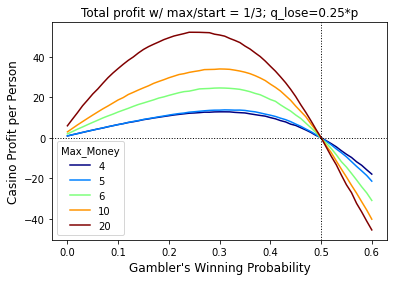

In [ ]:
#plot the profit pattern with different start_money and max_money 
#and the ratio of max/start money = 3
profit_patterns_vmax.to_csv('profit_qlose0.25_vmax.csv')
pp_vmax = profit_patterns_vmax.loc[:0.6].plot(
    cmap='jet', 
    title='Total profit w/ max/start = 3; q_lose=0.25*p',
)
pp_vmax.set_xlabel("Gambler's Winning Probability", fontsize=12)
pp_vmax.set_ylabel('Casino Profit per Person', fontsize=12)
pp_vmax.legend(title='Max_Money',fontsize=10)
pp_vmax.axvline(0.5, lw=1, color='k', linestyle=':')
pp_vmax.axhline(0., lw=1, color='k', linestyle=':')


In [ ]:
#find the profit pattern with different q_lose_ratio 
profit_patterns_vqlose = pd.DataFrame({
    q_lose_ratio: pd.Series({
        _: sim_avg_profit(_, q_lose_ratio, 0.5, 6, 2, 5000, 240, 0.0)
        for _ in np.linspace(0.0, 0.6, 61)
    })
    for q_lose_ratio in [0.01, 0.05, 0.25, 0.75]
})

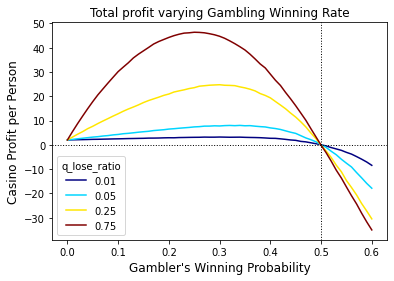

In [ ]:
#plot the profit pattern with different q_lose_ratio 
profit_patterns_vqlose.to_csv('profit_pattern_vqlose.csv')
pp_vqlose = profit_patterns_vqlose.loc[:0.6].plot(
    cmap='jet', 
    title='Total profit varying Gambling Winning Rate',
)
pp_vqlose.set_xlabel("Gambler's Winning Probability", fontsize=12)
pp_vqlose.set_ylabel('Casino Profit per Person', fontsize=12)
pp_vqlose.legend(title='q_lose_ratio',fontsize=10)
pp_vqlose.axvline(0.5, lw=1, color='k', linestyle=':')
pp_vqlose.axhline(0., lw=1, color='k', linestyle=':')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in add
  if sys.path[0] == '':


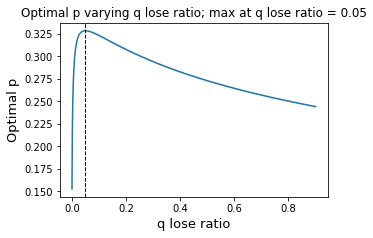

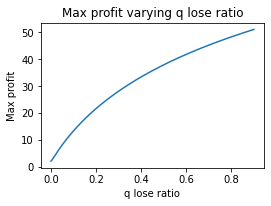

In [ ]:
# analytical solution with default parameter value set
def close_form(x, a):
    """
    analytical solution to mean profit distribution
    x: probability to win a game
    a: if a person loses, the probability to go back to the games with start money
    In this case, we assume q_win = 0.5, start_money = 2, max_money = 6 
    """
    logit = (1-x)/x
    factor = (logit ** 2 - 1) / (logit ** 6 - 1)

    left = 1 + (6 * factor / (1 - 2*x) - 2 / (1 - 2*x) + 240) / (
        factor * (-1 / (a*x) - 6 / (1 - 2*x) + 2) + 1 / (a * x) + 2 / (1 - 2*x) + 1
    )

    right = 2 - 6 * factor
    return left * right



def close_form_curve(a, idx=np.linspace(0, 0.5, 501)[1:-1]):
    return pd.Series(close_form(idx, a), index=idx)

#plot the figure to see how Optimal p(maximum profit point) is impacted by q_lose_ratio
#plot the figure to see how maximum profit is impacted by q_lose_ratio.
p_0 = np.linspace(0, 0.327, 2001)[1:-1]
p_1 = np.linspace(0.327, 0.332, 10001)
p_2 = np.linspace(0.332, 0.6, 1001)[1:-1]
profilt_patterns_closeform = pd.DataFrame({
    _: close_form_curve(_, np.concatenate([p_0, p_1, p_2]))
    for _ in np.linspace(0.00, 0.9, 2251)
})
closeform_idxmax = profilt_patterns_closeform.idxmax()
ax = closeform_idxmax[:].plot(
    title=f'Optimal p varying q lose ratio; max at q lose ratio = {closeform_idxmax.idxmax()}',
    # ylabel='Optimal p', xlabel='q lose ratio', 
    figsize=(4.8, 3.2)
)
ax.set_ylabel('Optimal p', fontsize=13)
ax.set_xlabel('q lose ratio', fontsize=13)
ax.axvline(closeform_idxmax.idxmax(), color='k', lw=1, linestyle='--')
plt.show()
ax = profilt_patterns_closeform.max()[:].plot(
    title=f'Max profit varying q lose ratio',
    ylabel='Max profit', xlabel='q lose ratio', figsize=(4, 8/3)
)
plt.show()

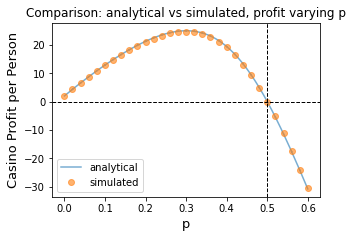

In [ ]:

#plot the comparison between analytical result and simulated result
#on casino profit varying p value
ax = pd.DataFrame({
    'analytical': profilt_patterns_closeform.loc[:, 0.25],
    'simulated': profit_patterns_vqlose.loc[:, 0.25][::2]
}).plot(
    style=['-', 'o'], alpha=0.6,
    title='Comparison: analytical vs simulated, profit varying p',
    figsize=(4.8, 3.2),

)

ax.axhline(0., linestyle='--', lw=1, color='k')
ax.axvline(0.5, linestyle='--', lw=1, color='k')
ax.set_ylabel('Casino Profit per Person', fontsize=13)
ax.set_xlabel('p', fontsize=13)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=12b33795-9eb6-4179-90c6-ac2db557d674' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>